## **Import Module**

In [1]:
from pathlib import Path
import math
from datetime import datetime
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

# Import modules
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.feature_selection import RFECV

from sklearn.pipeline import Pipeline

import shap
shap.initjs()

## **Set Environment**

In [2]:
# Set pd.options to add slide bars
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [ ]:
# Set up directory
# working_directory = Path.cwd()
# data_directory = working_directory/"data"
# data_directory = working_directory/"drive/MyDrive/Nigeria Enhancing Maternal Health/data/_data"

## **Load Data**

In [3]:
df = pd.read_csv("dhaka_khulna_mymensingh_narayanganj_2013_2023_all_combined.csv", parse_dates=['datetime'])

## **Descriptive Statistics**

In [4]:
df.shape

(15524, 39)

In [5]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,15524,2018-04-25 00:00:00,2013-01-01 00:00:00,2015-08-29 00:00:00,2018-04-25 00:00:00,2020-12-20 00:00:00,2023-08-17 00:00:00,NaN
temp,15524.0,25.898396,10.6,22.666667,27.2,29.1,39.166667,4.649778
feelslike,15524.0,27.949029,9.4,22.6,28.6,33.5,43.3,6.454771
dew,15524.0,29.772823,-1.7,18.1,24.7,27.5,77.5,18.2183
humidity,15524.0,70.087619,11.1,61.3,73.2,83.5,98.2,17.207606
precip,15524.0,5.43504,0.0,0.0,0.048,5.1,266.5,13.020302
precipprob,15524.0,52.531564,0.0,0.0,100.0,100.0,100.0,49.937479
precipcover,15524.0,34.448524,0.0,0.0,8.33,75.0,100.0,40.18528
snow,2340.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
snowdepth,2345.0,0.024606,0.0,0.0,0.0,0.0,24.0,0.671351


In [36]:
df.describe(include='object').T

,count,unique,top,freq
preciptype,8158,1,rain,8158
sunrise,15524,15505,2015-01-16T06:44:47,2
sunset,15524,15504,2020-05-21T18:38:20,2
conditions,15524,7,"Rain, Partially cloudy",6447
description,12496,45,Clear conditions throughout the day.,3365
Division,15524,4,Dhaka,3881


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15524 entries, 0 to 15523
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   datetime                    15524 non-null  datetime64[ns]
 1   temp                        15524 non-null  float64       
 2   feelslike                   15524 non-null  float64       
 3   dew                         15524 non-null  float64       
 4   humidity                    15524 non-null  float64       
 5   precip                      15524 non-null  float64       
 6   precipprob                  15524 non-null  float64       
 7   precipcover                 15524 non-null  float64       
 8   preciptype                  8158 non-null   object        
 9   snow                        2340 non-null   float64       
 10  snowdepth                   2345 non-null   float64       
 11  windgust                    2763 non-null   float64   

**Null analysis**
* Drop 'preciptype', 'snow', 'snowdepth', 'description'
* 'sealevelpressure' --> Fill the mean 
* The pattern of 'visibility' and 'windgust' were changed after 2020, it can be assumed that changes could have made to the system 
* 'severerisk' first appeared in January 2020
* Drop 'severerisk', 'visibility' and 'windgust'

In [34]:
# Check columns that have at least one null
df.isna().sum()

datetime                          0
temp                              0
feelslike                         0
dew                               0
humidity                          0
precip                            0
precipprob                        0
precipcover                       0
preciptype                     7366
snow                          13184
snowdepth                     13179
windgust                      12761
winddir                           0
sealevelpressure               1205
cloudcover                        0
visibility                     1200
solarradiation                    0
solarenergy                       0
uvindex                           0
severerisk                    13184
sunrise                           0
sunset                            0
moonphase                         0
conditions                        0
description                    3028
river_discharge                   0
weathercode                       0
temperature_2m_mean         

In [7]:
null_cols = df.columns[df.isna().sum() > 0]
null_cols

Index(['preciptype', 'snow', 'snowdepth', 'windgust', 'sealevelpressure',
       'visibility', 'severerisk', 'description'],
      dtype='object')

In [4]:
df.drop(['preciptype', 'snow', 'snowdepth', 'description'], axis=1, inplace=True)

In [87]:
df[['sealevelpressure','visibility', 'severerisk', 'windgust']].describe()

,sealevelpressure,visibility,severerisk,windgust
count,14319.000000,14324.000000,2340.000000,2763.000000
mean,1008.231846,5.516434,25.512821,26.009627
std,5.797274,4.585897,21.289497,12.956338
min,991.600000,0.000000,5.000000,4.300000
25%,1003.500000,3.200000,10.000000,16.600000
50%,1008.300000,4.100000,10.000000,23.000000
75%,1013.200000,6.000000,30.000000,33.100000
max,1022.700000,31.000000,100.000000,92.500000


In [88]:
df[['sealevelpressure', 'visibility', 'severerisk', 'windgust']].head()

,sealevelpressure,visibility,severerisk,windgust
0,1011.5,2.1,NaN,NaN
1,1012.6,3.6,NaN,NaN
2,1012.5,2.8,NaN,NaN
3,1011.7,2.3,NaN,NaN
4,1012.1,2.2,NaN,NaN


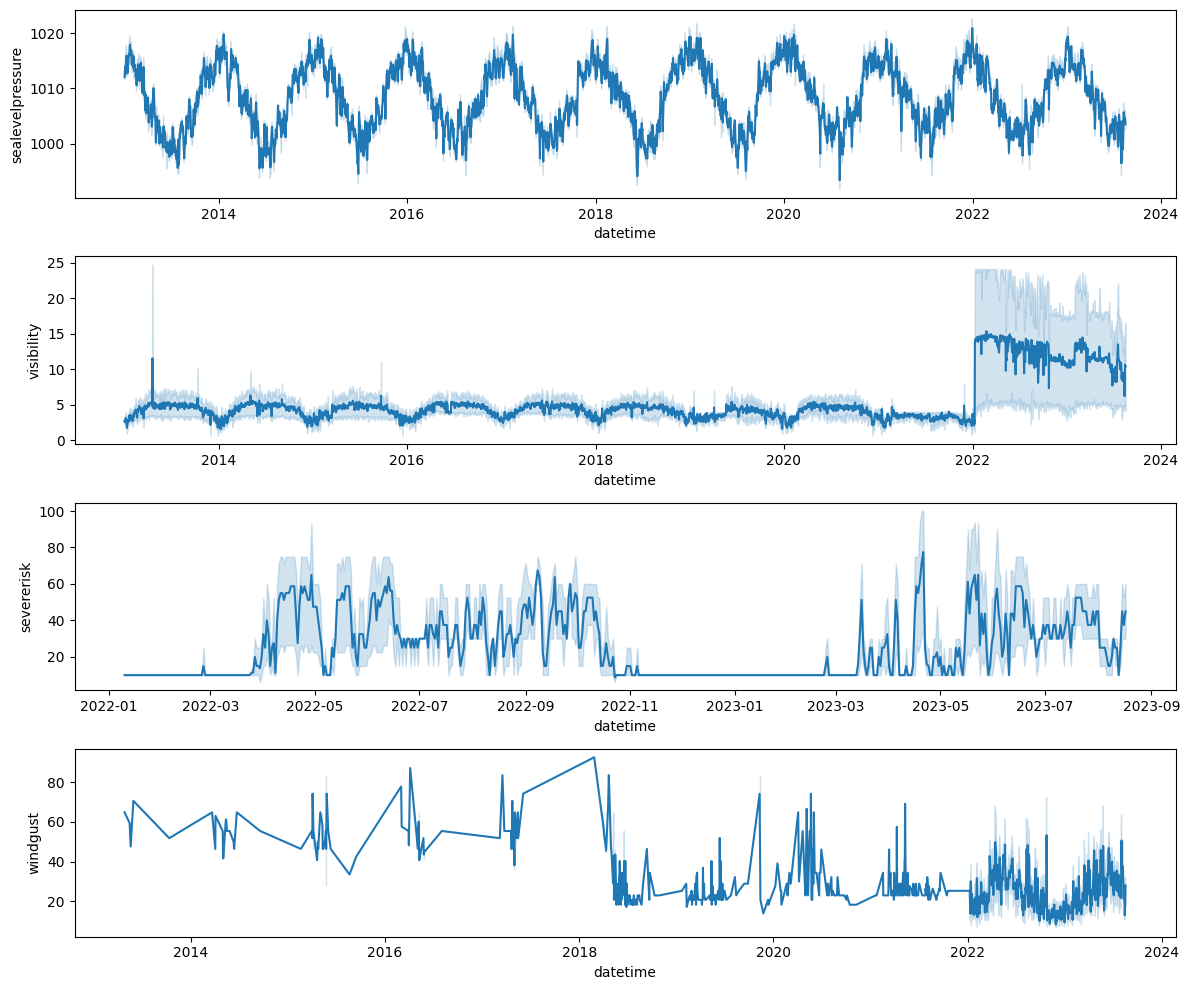

In [5]:
cols = ['sealevelpressure', 'visibility', 'severerisk', 'windgust']
plt.figure(figsize=(12, 10))
for i in range(len(cols)):
    ax = plt.subplot(4, 1, i+1)
    sns.lineplot(x=df['datetime'], y=df[cols[i]], ax=ax)
    plt.tight_layout()

In [89]:
# The first day that the 'severerisk' was recorded
idx = df['severerisk'].notna()
df.loc[idx]['datetime'].min()

Timestamp('2022-01-10 00:00:00')

In [90]:
df.head()

,datetime,temp,feelslike,dew,humidity,precip,precipprob,precipcover,windgust,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,river_discharge,weathercode,temperature_2m_mean,apparent_temperature_mean,precipitation_sum,rain_sum,precipitation_hours,et0_fao_evapotranspiration,feelslikemin,feelslikemax,windspeed,tempmax,tempmin,Division
0,2013-01-01,17.800000,17.800000,12.2,73.1,0.000,0.0,0.00,NaN,301.4,1011.5,27.6,2.1,170.7,14.7,7.0,NaN,2013-01-01T06:40:54,2013-01-01T17:23:03,0.63,Partially cloudy,0.22,0,17.4,17.0,0.0,0.0,0.0,3.01,11.100000,24.30,11.75,24.45,11.35,Dhaka
1,2013-01-01,17.700000,17.700000,9.5,62.1,0.000,0.0,0.00,NaN,332.8,1012.6,5.7,3.6,174.8,15.1,7.0,NaN,2013-01-01T06:42:37,2013-01-01T17:28:15,0.63,Clear,75.03,0,18.9,19.0,0.0,0.0,0.0,3.13,8.500000,26.00,9.40,26.00,9.80,Khulna
2,2013-01-01,16.700000,16.700000,9.8,66.7,0.000,0.0,0.00,NaN,316.3,1012.5,2.0,2.8,163.0,14.2,6.0,NaN,2013-01-01T06:42:59,2013-01-01T17:20:55,0.63,Clear,64.92,2,17.5,17.2,0.0,0.0,0.0,2.78,10.800000,25.10,11.90,25.10,10.80,Mymensingh
3,2013-01-01,21.333333,21.388889,58.1,65.7,0.016,100.0,16.67,NaN,215.7,1011.7,31.0,2.3,115.9,9.9,5.0,NaN,2013-01-01T06:49:46,2013-01-01T17:35:26,0.63,"Rain, Partially cloudy",152.11,2,17.9,17.8,0.0,0.0,0.0,2.96,16.055556,28.50,9.85,23.60,11.80,Narayanganj
4,2013-01-02,18.700000,18.700000,13.0,71.5,0.000,0.0,0.00,NaN,333.7,1012.1,10.4,2.2,167.0,14.3,6.0,NaN,2013-01-02T06:41:12,2013-01-02T17:23:43,0.67,Clear,0.22,2,18.0,18.2,0.0,0.0,0.0,2.90,11.700000,24.95,12.15,24.70,12.00,Dhaka


In [13]:
# # Calculate weekly average for 'sealevelpressure'
# week_mean = df.groupby('year_week')['sealevelpressure'].mean().reset_index().set_index('year_week')

KeyError: 'year_week'

In [ ]:
# # Replace naull with the same weeks' weekly average
# for i in range(len(df)):
#     if pd.isna(df.loc[i, 'sealevelpressure']):
#         yw = df.loc[i, 'year_week']
#         avg = week_mean.loc[yw, 'sealevelpressure']
#         df.loc[i, 'sealevelpressure'] = avg

# # Check null
# df['sealevelpressure'].isna().sum()

In [5]:
# Drop 'windgust', 'severerisk'
df.drop(['windgust', 'severerisk', 'visibility'], axis=1, inplace=True)

* Observe distribution of the dataset

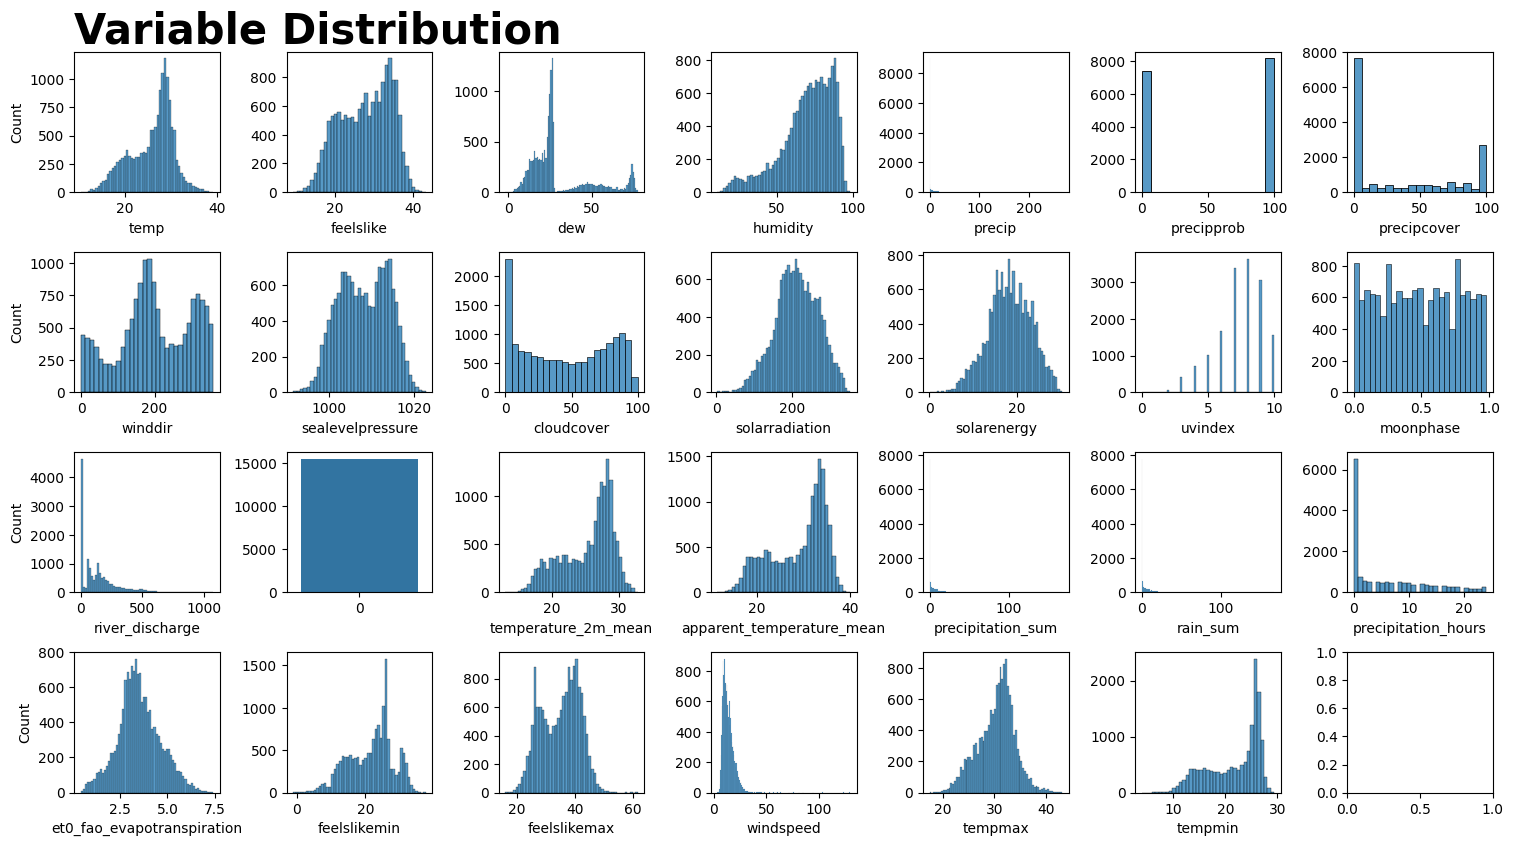

In [8]:
numerical_cols = [col for col in df if df[col].dtypes != 'O'] 

categorical_cols = [col for col in df if df[col].dtypes == 'O'] 
cols = numerical_cols + categorical_cols
cols_to_delete= ['datetime', 'Division', 'sunrise', 'sunset', 'conditions']
cols = [c for c in cols if c not in cols_to_delete]

# Plot distribution of variables
r = 4
c = 7
fig, ax =  plt.subplots(r, c, figsize=(15, 8))
fig.tight_layout(h_pad=2.2)  
plt.text(x=0, y=1.3, s="Variable Distribution", ha='left', va='top', transform=ax[0, 0].transAxes, fontsize=30, fontweight='bold')
for i in range(len(cols)):
    if df[cols[i]].dtype == np.number:
        sns.histplot(df[cols[i]], ax=ax[i//c, i%c])
    else:
        sns.countplot(df[cols[i]], ax=ax[i//c, i%c])
    if i % c != 0:
        ax[i//c, i%c].set_ylabel("");

# **Daily Average 'precip' of 4 Divisions**

## **Preprocess Dataset**
* Get the average of 'precip' for 'Dhaka', 'Khulna', 'Mymensingh', and 'Narayanganj'
* Fill missing 'sealevelpressure' with the previous value

In [6]:
# 'precipitation_sum' and 'rain_sum' are identical --> drop 'precipitation_sum'
df_daily = df.copy()
df_daily.drop(['conditions', 'Division', 'weathercode', 'precipitation_sum', 'sunrise', 'sunset'], axis=1, inplace=True)

In [7]:
# Calculate weekly average for 'sealevelpressure'
cols = df_daily.select_dtypes(exclude='object').columns.to_list()
daily_mean = df_daily.groupby('datetime')[cols].mean()
daily_mean.drop('datetime', axis=1, inplace=True)

In [62]:
daily_mean.head()

,temp,feelslike,dew,humidity,precip,precipprob,precipcover,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,moonphase,river_discharge,temperature_2m_mean,apparent_temperature_mean,rain_sum,precipitation_hours,et0_fao_evapotranspiration,feelslikemin,feelslikemax,windspeed,tempmax,tempmin
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,18.383333,18.397222,22.400,66.900,0.004,25.0,4.1675,291.550,1012.075,16.575,156.100,13.475,6.25,0.63,73.0700,17.925,17.750,0.000,0.0,2.9700,11.613889,25.975000,10.7250,24.7875,10.9375
2013-01-02,18.791667,18.766667,23.425,69.825,0.002,25.0,2.0825,308.400,1012.750,9.000,149.325,12.825,5.75,0.67,72.5175,18.700,19.225,0.000,0.0,2.8025,12.508333,25.970833,9.4750,25.4500,11.9000
2013-01-03,18.138889,18.097222,21.500,72.125,0.700,50.0,8.3325,161.325,1014.050,24.925,112.750,9.700,4.50,0.70,72.1425,18.375,19.150,0.575,1.5,1.3925,13.229167,24.226389,7.8750,22.9875,15.1125
2013-01-04,18.277778,18.166667,19.625,67.500,0.000,0.0,0.0000,256.400,1014.025,32.775,170.725,14.725,6.25,0.74,68.7625,18.800,19.450,0.000,0.0,2.4750,12.359722,25.948611,11.1125,25.2250,14.4000
2013-01-05,17.047222,16.850000,17.125,61.125,0.000,0.0,0.0000,257.925,1012.600,5.475,174.375,15.125,7.00,0.75,63.9950,17.825,17.525,0.000,0.0,2.9875,9.411111,25.425000,10.4000,24.6000,11.4750


In [8]:
# Fill missing 'sealevelpressure' with the previous value
daily_mean['sealevelpressure'] = daily_mean['sealevelpressure'].fillna(method='ffill')
daily_mean['sealevelpressure'].isna().sum()

0

### **Outlier Analysis**
* 'precip' has 323 outliers that is 8.32% of the entire dataset, which is relatively small, thus outliers will be ignored

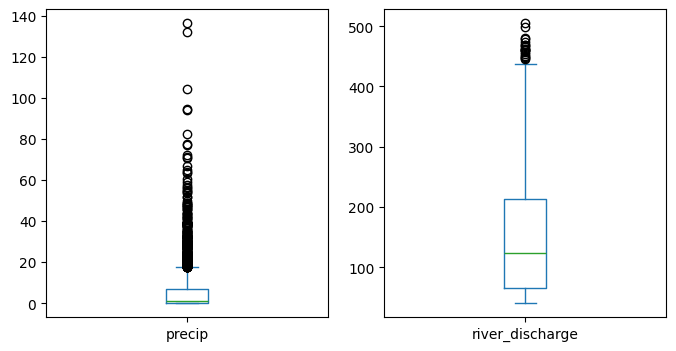

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.title("")
daily_mean['precip'].plot(kind='box', ax=ax1)
daily_mean['river_discharge'].plot(kind='box', ax=ax2);

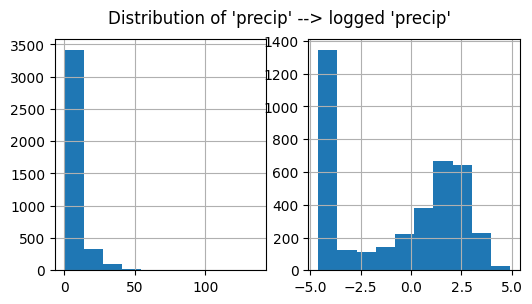

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
plt.suptitle("Distribution of 'precip' --> logged 'precip'")
logged_precip = np.log(daily_mean['precip']+0.01)
daily_mean['precip'].hist(ax=ax1)
logged_precip.hist(ax=ax2);

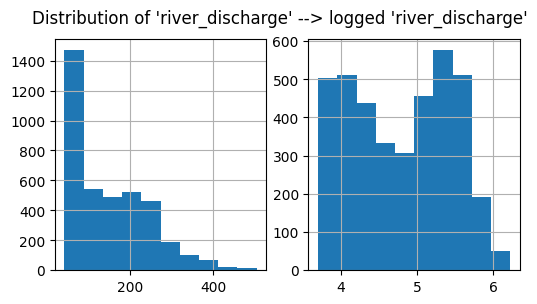

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
plt.suptitle("Distribution of 'river_discharge' --> logged 'river_discharge'")
logged_river_discharge = np.log(daily_mean['river_discharge']+0.01)
daily_mean['river_discharge'].hist(ax=ax1)
logged_river_discharge.hist(ax=ax2);

In [67]:
# Check outliers of 'precip'
q3, q1 = np.percentile(daily_mean['precip'], [75, 25])
iqr = q3 - q1
num_outliers = (daily_mean['precip'] > q3 + iqr*1.5).sum()
print("'precip'")
print("Number of observation", len(daily_mean['precip']))
print("Number of outliers: ", num_outliers)
print("Outlier ratio(%): ", round(num_outliers / len(daily_mean['precip']) * 100, 2))
print("Q3: ", q3, ", Q1: ", q1)
print("Upper threshold: ", q3 + iqr*1.5, "Lower threshold: ", q1 - iqr*1.5)
print("Max: ", daily_mean['precip'].max(), "Min: ", daily_mean['precip'].min())
# df_groupby_div_week

'precip'
Number of observation 3881
Number of outliers:  323
Outlier ratio(%):  8.32
Q3:  7.062 , Q1:  0.0
Upper threshold:  17.655 Lower threshold:  -10.593
Max:  136.425 Min:  0.0


In [68]:
# Check outliers of 'river_discharge'
q3, q1 = np.percentile(daily_mean['river_discharge'], [75, 25])
iqr = q3 - q1
num_outliers = (daily_mean['river_discharge'] > q3 + iqr*1.5).sum()
print("'river_discharge'")
print("Number of observation", len(daily_mean['river_discharge']))
print("Number of outliers: ", num_outliers)
print("Outlier ratio(%): ", round(num_outliers / len(daily_mean['river_discharge']) * 100, 2))
print("Q3: ", q3, ", Q1: ", q1)
print("Upper threshold: ", q3 + iqr*1.5, "Lower threshold: ", q1 - iqr*1.5)
print("Max: ", daily_mean['river_discharge'].max(), "Min: ", daily_mean['river_discharge'].min())
# df_groupby_div_week

'river_discharge'
Number of observation 3881
Number of outliers:  18
Outlier ratio(%):  0.46
Q3:  213.8075 , Q1:  65.08
Upper threshold:  436.89875000000006 Lower threshold:  -158.01125000000002
Max:  505.0475 Min:  40.2925


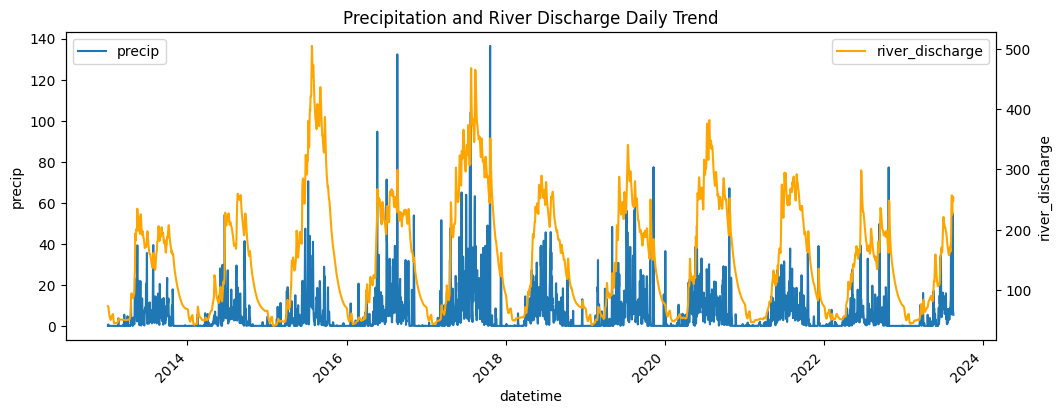

In [69]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()

plt.title("Precipitation and River Discharge Daily Trend")
sns.lineplot(x=daily_mean.index, y=daily_mean['precip'], ax=ax1, label='precip' )
sns.lineplot(x=daily_mean.index, y=daily_mean['river_discharge'], ax=ax2, color='orange', label='river_discharge') 

# ax1.set_xticks(ax1.get_xticks()[::8])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', va='top')
ax1.legend(loc='upper left');

### **Colliniality Analysis**
* Temperature-related features, 'temp', 'feelslike', 'temperature_2m_mean', 'apparent_temperature_mean', 'feelslikemin', 'feelslikemax', 'tempmin', and 'tempmax' show high colliniality
* 'sealevelpressure' has a negative colliniality to 'feelslike', 'temperature_2m_mean', 'apparent_temperature_mean', 'feelslikemin', 'feelslikemax', and 'tempmax'

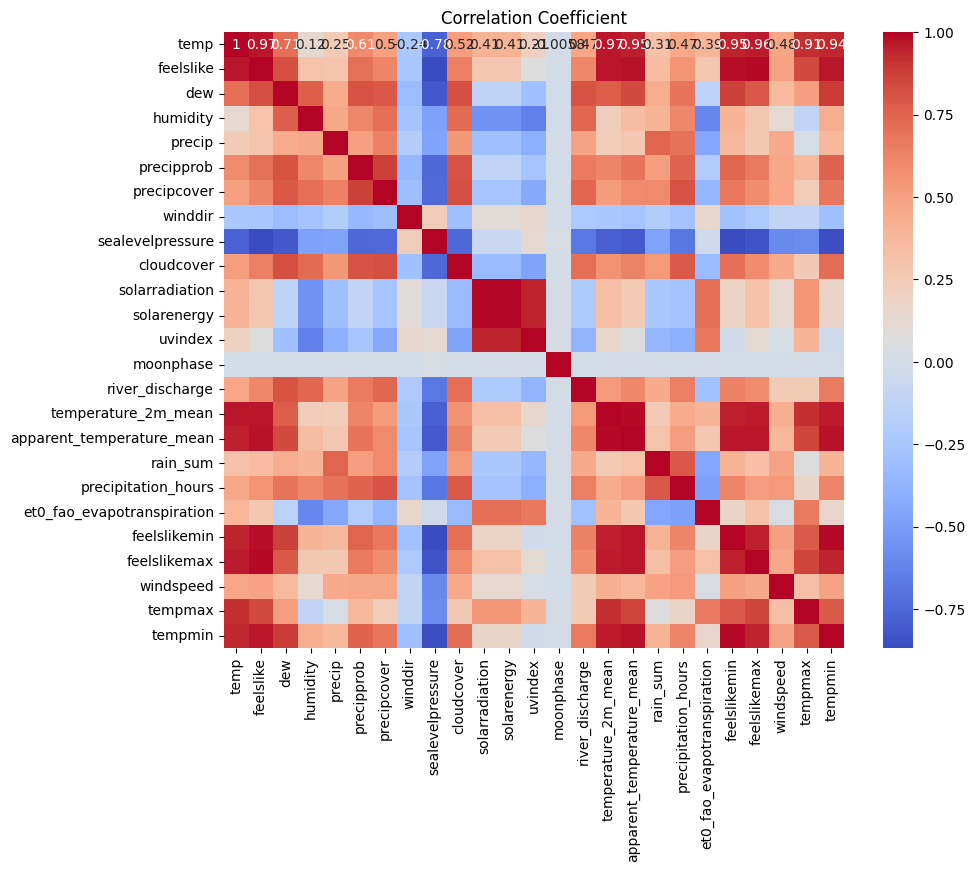

In [70]:
# Observe the correlation
cor = daily_mean.corr()

plt.figure(figsize=(10, 8))
plt.title("Correlation Coefficient")
sns.heatmap(cor, annot=True, cmap='coolwarm');

In [17]:
cor['temp'].sort_values()

sealevelpressure             -0.776848
winddir                      -0.235834
moonphase                    -0.005803
humidity                      0.124976
uvindex                       0.211849
precip                        0.251640
rain_sum                      0.314169
et0_fao_evapotranspiration    0.391505
solarradiation                0.408306
solarenergy                   0.408504
precipitation_hours           0.465432
river_discharge               0.471129
windspeed                     0.479138
precipcover                   0.498490
cloudcover                    0.516178
precipprob                    0.605780
dew                           0.713900
tempmax                       0.913247
tempmin                       0.935638
feelslikemin                  0.946476
apparent_temperature_mean     0.953027
feelslikemax                  0.957863
feelslike                     0.966480
temperature_2m_mean           0.969893
temp                          1.000000
Name: temp, dtype: float6

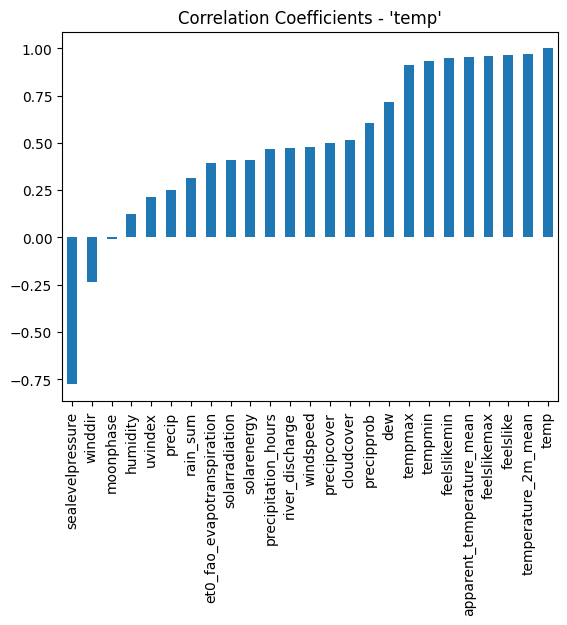

In [18]:
plt.title("Correlation Coefficients - 'temp'")
cor['temp'].sort_values().plot(kind='bar');

In [19]:
cor['sealevelpressure'].sort_values()

feelslikemin                 -0.868105
feelslike                    -0.864824
tempmin                      -0.854170
feelslikemax                 -0.837492
dew                          -0.810918
apparent_temperature_mean    -0.808589
temperature_2m_mean          -0.784275
temp                         -0.776848
cloudcover                   -0.750243
precipprob                   -0.747829
precipcover                  -0.739665
precipitation_hours          -0.683641
river_discharge              -0.675556
windspeed                    -0.595491
tempmax                      -0.590689
humidity                     -0.474586
rain_sum                     -0.470019
precip                       -0.460950
solarenergy                  -0.067232
solarradiation               -0.066904
et0_fao_evapotranspiration   -0.031709
moonphase                     0.024915
uvindex                       0.124746
winddir                       0.226902
sealevelpressure              1.000000
Name: sealevelpressure, d

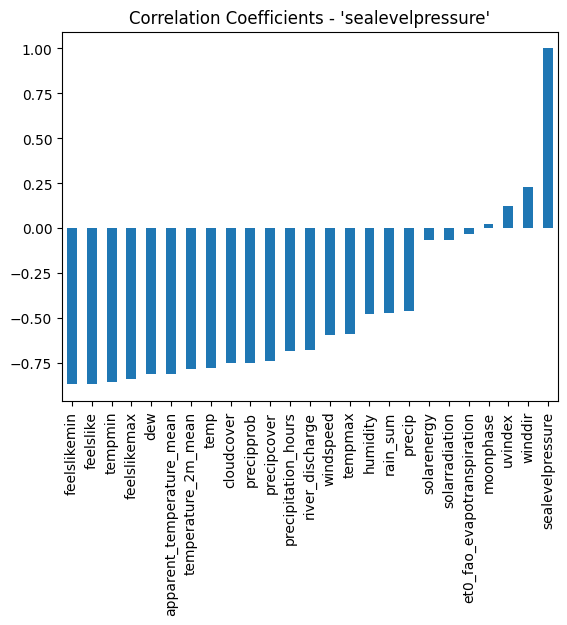

In [20]:
plt.title("Correlation Coefficients - 'sealevelpressure'")
cor['sealevelpressure'].sort_values().plot(kind='bar');

## **Building Model**
* Base and hyperparameter tuned models were created for XGBRegressor, RandomForestRegressor, and XGBRFRegressor with the entire features and the RFE selected features


**Entire Features**
||Tuned XGBRegressor|Tuned RandomForestRegressor|Tuned XGBRFRegressor|
| --- | --- | --- | --- |
|R2|0.666166|0.580152|0.666377|
|MAE|2.533397|2.704785|2.542604|
|MSE|22.114145|27.811999|22.100195|
|RMSE|4.702568|5.273708|4.701084|

**RFE Selected Features**
||Tuned XGBRegressor|Tuned RandomForestRegressor|Tuned XGBRFRegressor|
| --- | --- | --- | --- |
|R2|0.642650|0.585225|0.677111|
|MAE|2.627666|2.686943|2.603482|
|MSE|23.671919|27.475926|21.389164|
|RMSE|4.865380|5.241748|4.624842|

### **Dataset Preparation**


In [9]:
# Drop the target variable, 'precip', and highly correlated variables, 'precipcover', 'precipitation_hours', 'rain_sum'
X_daily = daily_mean.drop(['precip', 'precipcover', 'precipitation_hours', 'rain_sum'], axis=1)
# Predict 'precip'
y_daily = daily_mean[['precip']]

In [10]:
print(X_daily.shape, y_daily.shape)

(3881, 21) (3881, 1)


### **RFE Selected Dataset VS. the Entire Dataset**

### **Split Dataset - Train, Test, Validation**
* Train --> 2013 to 2019
* Test --> 2020 and 2021
* Validation --> 2022 and 2023

In [11]:
# Split train, test and validataion
# Train
X_train_daily = X_daily[X_daily.index.year.isin([yr for yr in range(2013, 2020, 1)])]
y_train_daily = y_daily[y_daily.index.year.isin([yr for yr in range(2013, 2020, 1)])]['precip'].values
# Test
X_test_daily = X_daily[X_daily.index.year.isin([2020, 2021])]
y_test_daily = y_daily[y_daily.index.year.isin([2020, 2021])]['precip'].values
# Validation
X_validation_daily = X_daily[X_daily.index.year.isin([2022, 2023])]
y_validation_daily = y_daily[y_daily.index.year.isin([2022, 2023])]['precip'].values

In [12]:
# Check the shape
print(X_train_daily.shape, y_train_daily.shape)
print(X_test_daily.shape, y_test_daily.shape)
print(X_validation_daily.shape, y_validation_daily.shape)

(2556, 21) (2556,)
(731, 21) (731,)
(594, 21) (594,)


### **Normalize the Dataset**

In [13]:
# Normalize train, test and validation datasets
scaler = MinMaxScaler().fit(X_train_daily)
X_train_daily_scaled = scaler.transform(X_train_daily)
X_test_daily_scaled = scaler.transform(X_test_daily)
X_validation_daily_scaled = scaler.transform(X_validation_daily)

In [14]:
# Create DataFrame
cols = X_train_daily.columns
X_train_daily_scaled = pd.DataFrame(X_train_daily_scaled, columns=cols)
X_test_daily_scaled = pd.DataFrame(X_test_daily_scaled, columns=cols)
X_validation_daily_scaled = pd.DataFrame(X_validation_daily_scaled, columns=cols)

### **Build Base Models with the Entire Dataset**
* RandomForestRegressor
* XGBRegressor
* XGBRFRegressor

|Metrics|XGBRegressor|RandomForestRegressor|XGBRFRegressor|
| --- | --- | --- | --- |
|R2|0.517263|0.618487|0.611303|
|MAE|2.969200|2.686932|2.704252|
|MSE|31.977930|25.272574|25.748431|
|RMSE|5.654903|5.027183|5.074291|

In [15]:
# Function to fit a model
def fit_model(model, X_training, y_training, random_state=327):
    fitted_model = model.fit(X_training, y_training)
    return fitted_model

# Function to create a model and return prediction
def get_prediction(fitted_model, X_testing):
    pred = fitted_model.predict(X_testing)
    return pred

# Function to evaluate model
def evaluate_model(metric, prediction, y_testing):
    return metric(y_testing, prediction)

In [16]:
# Parameters used for model creation and evaluation 
X_train_daily = X_train_daily_scaled
X_test_daily = X_test_daily_scaled
predictions_daily = {}
score_results_daily = {}

In [17]:
models = [xgb.XGBRegressor(), RandomForestRegressor(), xgb.XGBRFRegressor()]
model_names = ['XGBRegressor', 'RandomForestRegressor', 'XGBRFRegressor']
metrics = [r2_score, mean_absolute_error, mean_squared_error]

for i in range(len(models)):
    model = fit_model(models[i], X_train_daily, y_train_daily)
    pred = get_prediction(model, X_test_daily)
    predictions_daily[model_names[i]] = pred
    scores = []
    for j in range(len(metrics)):
        scores.append(evaluate_model(metrics[j], pred, y_test_daily))
        if metrics[j] == mean_squared_error:
            scores.append(np.sqrt(evaluate_model(metrics[j], pred, y_test_daily)))
    score_results_daily[model_names[i]] = scores

### **Performance Metrics for Base Models with the Entire Dataset***
* RandomForestRegressor
* XGBRegressor
* XGBRFRegressor

In [18]:
# Base model performance scores
metrics.append('root mean squared error')
pd.DataFrame(score_results_daily, index=['R2', 'MAE', 'MSE', 'RMSE'])

,XGBRegressor,RandomForestRegressor,XGBRFRegressor
R2,0.517263,0.618487,0.611303
MAE,2.969200,2.686932,2.704252
MSE,31.977930,25.272574,25.748431
RMSE,5.654903,5.027183,5.074291


### **Hyperparameter Tuning with the Entire Dataset**

* RandomForestRegressor model
* best_rfr_params = {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}

||Tuned XGBRegressor|Tuned RandomForestRegressor|Tuned XGBRFRegressor|
| --- | --- | --- | --- |
|R2|0.666166|0.580152|0.666377|
|MAE|2.533397|2.704785|2.542604|
|MSE|22.114145|27.811999|22.100195|
|RMSE|4.702568|5.273708|4.701084|

-- Skip the below cell from the next time

In [19]:
# Define the parameter grid
rfr_params = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': [None, 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rfr_model = RandomForestRegressor(random_state=327)

# Instantiate the random search model
rfr_random_search = RandomizedSearchCV(estimator=rfr_model, 
                                       param_distributions=rfr_params, 
                                       n_iter=100, 
                                       cv=5, 
                                       verbose=2, 
                                       n_jobs=-1)

# Fit rfr_random_search and get the best hyperparameters
rfr_random_search.fit(X_train_daily_scaled, y_train_daily)
best_rfr_params = rfr_random_search.best_params_

# Create RandomForestRegressor with the best hyperparameters
best_rfr_model = RandomForestRegressor(**best_rfr_params)

# Train the model
best_rfr_model.fit(X_train_daily_scaled, y_train_daily)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomForestRegressor(max_depth=90, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=5, n_estimators=1000)

In [20]:
print(best_rfr_params)

{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}


-- Run the below cell to create the best RandomForestRegressor model

In [272]:
# Best hyperparameters for RandomForestRegressor
best_rfr_params = {'n_estimators': 1000, 
                   'min_samples_split': 5, 
                   'min_samples_leaf': 4, 
                   'max_features': 'sqrt', 
                   'max_depth': 90, 
                   'bootstrap': True}
# Best RandomForestRegressor model
best_rfr_model = RandomForestRegressor(**best_rfr_params)
# Train the model
best_rfr_model.fit(X_train_daily, y_train_daily)

RandomForestRegressor(bootstrap=False, max_depth=70, max_features=None,
                      min_samples_leaf=4, n_estimators=400)

* XGBoostRegressor
* best_xgb_params = {'reg_lambda': 3, 'reg_alpha': 2, 'objective': 'reg:squarederror', 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8, 'booster': 'gbtree'}

-- Skip the below cell from the next time

In [21]:
# Define the parameter grid
xgb_params = {
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'min_child_weight': [1, 2, 3],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0.5, 1, 2],
    'reg_lambda': [1, 2, 3],
    'gamma': [0, 1, 2]
}

# Create an XGBRegressor object
xgb_model = xgb.XGBRegressor(random_state=327)

# Create a RandomizedSearchCV object
xgb_random_search = RandomizedSearchCV(
                    estimator=xgb_model,
                    param_distributions=xgb_params,
                    n_iter=100,
                    cv=5,
                    scoring='neg_mean_absolute_error',
                    verbose=5,
                    n_jobs=12
)

# Fit xgb_random_search and get the best hyperparameters
xgb_random_search.fit(X_train_daily_scaled, y_train_daily)
best_xgb_params = xgb_random_search.best_params_

# Create xgb.XGBRegressor with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(**best_xgb_params)

# Train the model
best_xgb_model.fit(X_train_daily_scaled, y_train_daily)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
print(best_xgb_params)

{'reg_lambda': 3, 'reg_alpha': 2, 'objective': 'reg:squarederror', 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8, 'booster': 'gbtree'}


-- Run the below cell to create the best XGBRegressor model

In [273]:
# Best hyperparameters for XGBRegressor
best_xgb_params = {'reg_lambda': 3, 
                   'reg_alpha': 2, 
                   'objective': 'reg:squarederror', 
                   'n_estimators': 300, 
                   'min_child_weight': 1, 
                   'max_depth': 15, 
                   'learning_rate': 0.1, 
                   'gamma': 1, 
                   'colsample_bytree': 0.8, 
                   'booster': 'gbtree'}
# Create xgb.XGBRegressor with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(**best_xgb_params)

# Train the model
best_xgb_model.fit(X_train_daily, y_train_daily)               

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

* XGBRFRegressor
* best_xgbrf_model = {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 4, 'max_depth': 20, 'gamma': 0.2, 'colsample_bytree': 0.6}

-- Skip the below cell from the next time

In [23]:
# Define the hyperparameter search space
xgbrf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgbrf_model = xgb.XGBRFRegressor(random_state=327)

# Create a RandomizedSearchCV object
xgbrf_random_search = RandomizedSearchCV(
                      estimator=xgbrf_model,
                      param_distributions=xgbrf_params,
                      n_iter=100,
                      cv=5,
                      verbose=2,
                      n_jobs=-1
)

# Fit xgbrf_random_search and get the best hyperparameters
xgbrf_random_search.fit(X_train_daily_scaled, y_train_daily)
best_xgbrf_params = xgbrf_random_search.best_params_

# Create xgb.XGBRegressor with the best hyperparameters
best_xgbrf_model = xgb.XGBRFRegressor(**best_xgbrf_params)

# Train the model
best_xgbrf_model.fit(X_train_daily_scaled, y_train_daily)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.6, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0.2,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=20, max_leaves=None,
               min_child_weight=4, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [24]:
print(best_xgbrf_params)                   

{'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 4, 'max_depth': 20, 'gamma': 0.2, 'colsample_bytree': 0.6}


-- Run the below cell to create the best XGBRFRegressor model

In [274]:
# Best hyperparameters for XGBRFRegressor
best_xgbrf_params = {'subsample': 0.6, 
                     'n_estimators': 200, 
                     'min_child_weight': 4, 
                     'max_depth': 20, 
                     'gamma': 0.2, 
                     'colsample_bytree': 0.6}

# Create xgb.XGBRFRegressor with the best hyperparameters
best_xgbrf_model = xgb.XGBRegressor(**best_xgbrf_params)

# Train the model
best_xgbrf_model.fit(X_train_daily, y_train_daily)               

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### **Performance Metrics for the Best Models with the Entire Dataset**
* RandomForestRegressor
* XGBRegressor
* XGBRFRegressor

In [25]:
# Fit the RandomizedSearchCV object to the data
tuned_models = [best_rfr_model, best_xgb_model, best_xgbrf_model]
tuned_model_names = ['Tuned XGBRegressor', 'Tuned RandomForestRegressor', 'Tuned XGBRFRegressor']
metrics = [r2_score, mean_absolute_error, mean_squared_error]
tuned_score_results_daily = {}

for i in range(len(tuned_models)):
    model = tuned_models[i]
    pred = get_prediction(model, X_test_daily)
    predictions_daily[tuned_model_names[i]] = pred
    scores = []
    for j in range(len(metrics)):
        scores.append(evaluate_model(metrics[j], pred, y_test_daily))
        if metrics[j] == mean_squared_error:
            scores.append(np.sqrt(evaluate_model(metrics[j], pred, y_test_daily)))
    tuned_score_results_daily[tuned_model_names[i]] = scores

In [26]:
print("Performance Score for 'daily_mean' with the entire dataset")
pd.DataFrame(tuned_score_results_daily, index=['R2', 'MAE', 'MSE', 'RMSE'])

Performance Score for 'daily_mean' with the entire dataset


,Tuned XGBRegressor,Tuned RandomForestRegressor,Tuned XGBRFRegressor
R2,0.666166,0.580152,0.666377
MAE,2.533397,2.704785,2.542604
MSE,22.114145,27.811999,22.100195
RMSE,4.702568,5.273708,4.701084


### **Feature Selection - RFECV**

In [29]:
# Function to return selected features
def get_rfecv_score(X_training, y_training):
    selected_features = []
    rfe = RFECV(estimator=xgb.XGBRegressor(), cv=4, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    rfe.fit(X_training, y_training)

    for i in range(X_training.shape[1]):
        if rfe.support_[i]:
            selected_features.append(X_training.columns[i])

    return selected_features

In [36]:
# Print features selected by RFE
selected_features = get_rfecv_score(X_train_daily_scaled, y_train_daily)

Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


In [37]:
# Dataframe with the selected columns
X_train_daily_rfe = X_train_daily_scaled[selected_features]
X_test_daily_rfe = X_test_daily_scaled[selected_features]
X_validation_daily_rfe = X_validation_daily_scaled[selected_features]

In [38]:
# Check the shape
print(X_train_daily_rfe.shape, y_train_daily.shape)
print(X_test_daily_rfe.shape, y_test_daily.shape)
print(X_validation_daily_rfe.shape, y_validation_daily.shape)
X_train_daily_rfe .head(3)

(2556, 11) (2556,)
(731, 11) (731,)
(594, 11) (594,)


,humidity,precipprob,sealevelpressure,solarradiation,uvindex,river_discharge,et0_fao_evapotranspiration,feelslikemin,feelslikemax,windspeed,tempmax
0,0.565823,0.25,0.699321,0.300044,0.482759,0.070526,0.349020,0.270849,0.232728,0.115829,0.264062
1,0.615190,0.25,0.725509,0.269940,0.413793,0.069338,0.322745,0.300554,0.232578,0.084608,0.295441
2,0.654008,0.50,0.775946,0.107421,0.241379,0.068531,0.101569,0.324493,0.169878,0.044646,0.178804


### **Build Base Models with RFE Selected Dataset**
* RandomForestRegressor
* XGBRegressor
* XGBRFRegressor

||XGBRegressor|RandomForestRegressor|XGBRFRegressor|
| --- | --- | --- | --- |
|R2|0.517263|0.618487|0.611303|
|MAE|2.969200|2.686932|2.704252|
|MSE|31.977930|25.272574|25.748431|
|RMSE|5.654903|5.027183|5.074291|

In [43]:
# Parameters used for model creation and evaluation 
X_train_daily= X_train_daily_rfe
X_test_daily = X_test_daily_rfe
predictions_daily_rfe = {}
score_results_daily_rfe = {}

In [44]:
models = [xgb.XGBRegressor(), RandomForestRegressor(), xgb.XGBRFRegressor()]
model_names = ['XGBRegressor', 'RandomForestRegressor', 'XGBRFRegressor']
metrics = [r2_score, mean_absolute_error, mean_squared_error]

for i in range(len(models)):
    model = fit_model(models[i], X_train_daily, y_train_daily)
    pred = get_prediction(model, X_test_daily)
    predictions_daily_rfe[model_names[i]] = pred
    scores = []
    for j in range(len(metrics)):
        scores.append(evaluate_model(metrics[j], pred, y_test_daily))
        if metrics[j] == mean_squared_error:
            scores.append(np.sqrt(evaluate_model(metrics[j], pred, y_test_daily)))
    score_results_daily_rfe[model_names[i]] = scores

### **Performance Metrics for Base Models**
* RandomForestRegressor
* XGBRegressor
* XGBRFRegressor

In [45]:
# Base model performance scores
metrics.append('root mean squared error')
pd.DataFrame(score_results_daily, index=['R2', 'MAE', 'MSE', 'RMSE'])

,XGBRegressor,RandomForestRegressor,XGBRFRegressor
R2,0.517263,0.618487,0.611303
MAE,2.969200,2.686932,2.704252
MSE,31.977930,25.272574,25.748431
RMSE,5.654903,5.027183,5.074291


### **Hyperparameter Tuning with the RFE Selected Features**
* RandomForestRegressor
* XGBRegressor
* XGBRFRegressor

||Tuned XGBRegressor|Tuned RandomForestRegressor|Tuned XGBRFRegressor|
| --- | --- | --- | --- |
|R2|0.642650|0.585225|0.677111|
|MAE|2.627666|2.686943|2.603482|
|MSE|23.671919|27.475926|21.389164|
|RMSE|4.865380|5.241748|4.624842|


* RandomForestRegressor model
* best_rfr_params = {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}

-- Skip the below cell from the next time

In [46]:
# Define the parameter grid
rfr_params = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': [None, 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rfr_model = RandomForestRegressor(random_state=327)

# Instantiate the random search model
rfr_random_search = RandomizedSearchCV(estimator=rfr_model, 
                                       param_distributions=rfr_params, 
                                       n_iter=100, 
                                       cv=5, 
                                       verbose=2, 
                                       n_jobs=-1)

# Fit rfr_random_search and get the best hyperparameters
rfr_random_search.fit(X_train_daily_scaled, y_train_daily)
best_rfr_params = rfr_random_search.best_params_

# Create RandomForestRegressor with the best hyperparameters
best_rfr_model = RandomForestRegressor(**best_rfr_params)

# Train the model
best_rfr_model.fit(X_train_daily, y_train_daily)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomForestRegressor(max_depth=80, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=1000)

In [47]:
print(best_rfr_params)

{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}


-- Run the below cell to create the best RandomForestRegressor model

In [54]:
# Best hyperparameters for RandomForestRegressor
best_rfr_params = {'n_estimators': 1000, 
                   'min_samples_split': 2, 
                   'min_samples_leaf': 4, 
                   'max_features': 'sqrt', 
                   'max_depth': 80, 
                   'bootstrap': True}
# Best RandomForestRegressor model
best_rfr_model = RandomForestRegressor(**best_rfr_params)
# Train the model
best_rfr_model.fit(X_train_daily, y_train_daily)

RandomForestRegressor(max_depth=80, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=1000)

* XGBoostRegressor
* best_xgb_params = {'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8, 'booster': 'gbtree'}

-- Skip the below cell from the next time

In [57]:
# Define the parameter grid
xgb_params = {
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'min_child_weight': [1, 2, 3],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0.5, 1, 2],
    'reg_lambda': [1, 2, 3],
    'gamma': [0, 1, 2]
}

# Create an XGBRegressor object
xgb_model = xgb.XGBRegressor(random_state=327)

# Create a RandomizedSearchCV object
xgb_random_search = RandomizedSearchCV(
                    estimator=xgb_model,
                    param_distributions=xgb_params,
                    n_iter=100,
                    cv=5,
                    scoring='neg_mean_absolute_error',
                    verbose=5,
                    n_jobs=12
)

# Fit xgb_random_search and get the best hyperparameters
xgb_random_search.fit(X_train_daily_scaled, y_train_daily)
best_xgb_params = xgb_random_search.best_params_

# Create xgb.XGBRegressor with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(**best_xgb_params)

# Train the model
best_xgb_model.fit(X_train_daily, y_train_daily)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
print(best_xgb_params)

{'reg_lambda': 1, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.8, 'booster': 'gbtree'}


-- Run the below cell to create the best XGBRegressor model

In [ ]:
# Best hyperparameters for XGBRegressor
best_xgb_params = {'reg_lambda': 1, 
                   'reg_alpha': 1, 
                   'objective': 'reg:squarederror', 
                   'n_estimators': 200, 
                   'min_child_weight': 1, 
                   'max_depth': 15, 
                   'learning_rate': 0.1, 
                   'gamma': 1, 
                   'colsample_bytree': 0.8, 
                   'booster': 'gbtree'}
# Create xgb.XGBRegressor with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(**best_xgb_params)

# Train the model
best_xgb_model.fit(X_train_daily, y_train_daily)               

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

* XGBRFRegressor
* best_xgbrf_model = {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': None, 'gamma': 0.4, 'colsample_bytree': 0.6}

-- Skip the below cell from the next time

In [59]:
# Define the hyperparameter search space
xgbrf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgbrf_model = xgb.XGBRFRegressor(random_state=327)

# Create a RandomizedSearchCV object
xgbrf_random_search = RandomizedSearchCV(
                      estimator=xgbrf_model,
                      param_distributions=xgbrf_params,
                      n_iter=100,
                      cv=5,
                      verbose=2,
                      n_jobs=-1
)

# Fit xgbrf_random_search and get the best hyperparameters
xgbrf_random_search.fit(X_train_daily_scaled, y_train_daily)
best_xgbrf_params = xgbrf_random_search.best_params_

# Create xgb.XGBRegressor with the best hyperparameters
best_xgbrf_model = xgb.XGBRFRegressor(**best_xgbrf_params)

# Train the model
best_xgbrf_model.fit(X_train_daily, y_train_daily)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=0.6, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=0.4,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=2, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=100, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [60]:
print(best_xgbrf_params)                   

{'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': None, 'gamma': 0.4, 'colsample_bytree': 0.6}


-- Run the below cell to create the best XGBRFRegressor model

In [ ]:
# Best hyperparameters for XGBRFRegressor
best_xgbrf_params = {'subsample': 0.8, 
                     'n_estimators': 100, 
                     'min_child_weight': 2, 
                     'max_depth': None, 
                     'gamma': 0.4, 
                     'colsample_bytree': 0.6}

# Create xgb.XGBRFRegressor with the best hyperparameters
best_xgbrf_model = xgb.XGBRegressor(**best_xgbrf_params)

# Train the model
best_xgbrf_model.fit(X_train_daily, y_train_daily)               

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### **Performance Metrics for the Best Models**
* RandomForestRegressor
* XGBRegressor
* XGBRFRegressor

In [62]:
# Fit the RandomizedSearchCV object to the data
tuned_models = [best_rfr_model, best_xgb_model, best_xgbrf_model]
tuned_model_names = ['Tuned XGBRegressor', 'Tuned RandomForestRegressor', 'Tuned XGBRFRegressor']
metrics = [r2_score, mean_absolute_error, mean_squared_error]
tuned_score_results_daily = {}

for i in range(len(tuned_models)):
    model = tuned_models[i]
    pred = get_prediction(model, X_test_daily)
    predictions_daily[tuned_model_names[i]] = pred
    scores = []
    for j in range(len(metrics)):
        scores.append(evaluate_model(metrics[j], pred, y_test_daily))
        if metrics[j] == mean_squared_error:
            scores.append(np.sqrt(evaluate_model(metrics[j], pred, y_test_daily)))
    tuned_score_results_daily[tuned_model_names[i]] = scores

In [64]:
print("Performance Score for 'daily_mean' with RFE Selected Features")
pd.DataFrame(tuned_score_results_daily, index=['R2', 'MAE', 'MSE', 'RMSE'])

Performance Score for 'daily_mean' with RFE Selected Features


,Tuned XGBRegressor,Tuned RandomForestRegressor,Tuned XGBRFRegressor
R2,0.642650,0.585225,0.677111
MAE,2.627666,2.686943,2.603482
MSE,23.671919,27.475926,21.389164
RMSE,4.865380,5.241748,4.624842


# **Weekly Average 'precip' of 4 Divisions**
'precipitation_sum' and  'rain_sum' are identical --> drop 'precipitation_sum'

## **Preproces Dataset**

In [65]:
# Check 'precipitation_sum' and 'rain_sum' are identical
df['precipitation_sum'].equals(df['rain_sum']) 

True

* Aggregate values by 'year_week'

In [66]:
df['year_week'] = df['datetime'].dt.strftime('%Y_%U')

-- Restore Point

In [67]:
# copy df and remove columns
df_weekly = df.copy()
df_weekly.drop(['datetime', 'conditions', 'Division', 'weathercode', 'precipitation_sum'], axis=1, inplace=True)

In [68]:
# Calculate weekly average for 'sealevelpressure'
week_mean = df_weekly.groupby('year_week')['sealevelpressure'].mean().reset_index().set_index('year_week')

In [69]:
# Replace naull with the same weeks' weekly average
for i in range(len(df)):
    if pd.isna(df_weekly.loc[i, 'sealevelpressure']):
        yw = df_weekly.loc[i, 'year_week']
        avg = week_mean.loc[yw, 'sealevelpressure']
        df_weekly.loc[i, 'sealevelpressure'] = avg

# Check null
df_weekly['sealevelpressure'].isna().sum()

0

In [70]:
# Aggregate and calculate the mean for each numerical column on a weekly basis, 'year_week'
nume_cols = df_weekly.select_dtypes(exclude='object').columns.to_list()
df_groupby_div_week = df.groupby('year_week')[nume_cols].mean()
df_groupby_div_week.head()

,temp,feelslike,dew,humidity,precip,precipprob,precipcover,winddir,sealevelpressure,cloudcover,solarradiation,solarenergy,uvindex,moonphase,river_discharge,temperature_2m_mean,apparent_temperature_mean,rain_sum,precipitation_hours,et0_fao_evapotranspiration,feelslikemin,feelslikemax,windspeed,tempmax,tempmin
year_week,,,,,,,,,,,,,,,,,,,,,,,,,
2013_00,18.127778,18.055556,20.815000,67.495000,0.141200,20.000000,2.916500,255.120000,1013.100000,17.750000,152.655000,13.170000,5.950000,0.698000,70.097500,18.325000,18.620000,0.115000,0.300000,2.525500,11.824444,25.509167,9.917500,24.610000,12.765000
2013_01,14.230159,13.917857,12.850000,59.889286,0.000000,0.000000,0.000000,220.707143,1014.992857,13.792857,179.589286,15.478571,6.857143,0.767143,55.618929,15.453571,14.464286,0.025000,0.107143,2.711429,6.739087,22.536905,12.364286,21.264286,8.980357
2013_02,19.380952,19.252778,20.035714,60.439286,0.000000,0.000000,0.000000,233.160714,1014.871429,19.217857,175.842857,15.153571,6.857143,0.145714,53.249286,18.385714,18.553571,0.000000,0.000000,3.107500,12.112698,27.002183,9.858929,26.205357,12.101786
2013_03,17.464683,17.265873,14.989286,53.728571,0.000857,3.571429,0.892857,242.503571,1017.032143,8.085714,194.110714,16.721429,7.214286,0.371429,57.650357,17.907143,17.228571,0.021429,0.107143,3.403571,9.377381,25.672421,14.337500,25.612500,11.407143
2013_04,18.046825,17.900000,14.371429,52.042857,0.000000,0.000000,0.000000,235.689286,1015.621429,35.275000,175.000000,15.096429,6.821429,0.607500,45.617857,18.328571,18.014286,0.003571,0.035714,3.231071,10.237897,26.016865,12.371429,25.462500,11.476786


### **Outlier Analysis**

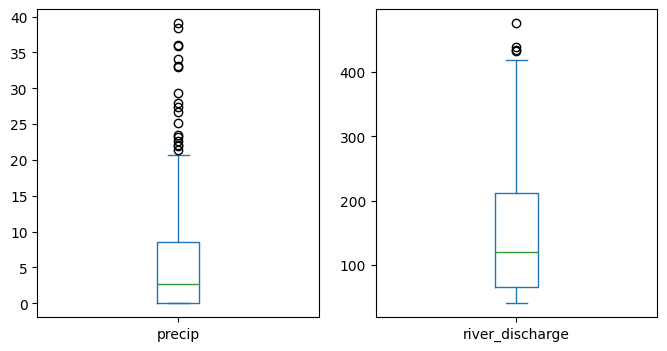

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.title("")
df_groupby_div_week['precip'].plot(kind='box', ax=ax1)
df_groupby_div_week['river_discharge'].plot(kind='box', ax=ax2);

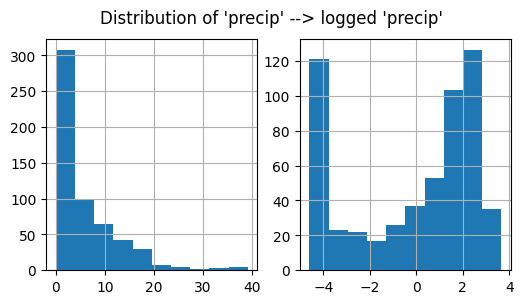

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
plt.suptitle("Distribution of 'precip' --> logged 'precip'")
logged_precip = np.log(df_groupby_div_week['precip']+0.01)
df_groupby_div_week['precip'].hist(ax=ax1)
logged_precip.hist(ax=ax2);

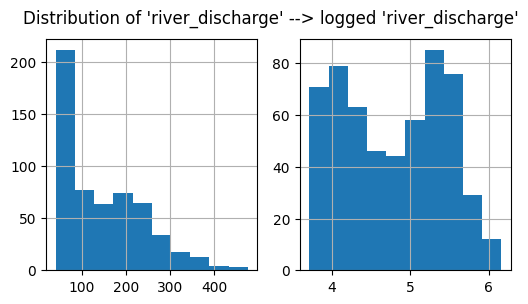

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
plt.suptitle("Distribution of 'river_discharge' --> logged 'river_discharge'")
logged_river_discharge = np.log(df_groupby_div_week['river_discharge']+0.01)
df_groupby_div_week['river_discharge'].hist(ax=ax1)
logged_river_discharge.hist(ax=ax2);

In [74]:
# Check outliers of 'precip'
q3, q1 = np.percentile(df_groupby_div_week['precip'], [75, 25])
iqr = q3 - q1
num_outliers = (df_groupby_div_week['precip'] > q3 + iqr*1.5).sum()
print("'precip'")
print("Number of observation", len(df_groupby_div_week['precip']))
print("Number of outliers: ", num_outliers)
print("Q3: ", q3, ", Q1: ", q1)
print("Upper threshold: ", q3 + iqr*1.5, "Lower threshold: ", q1 - iqr*1.5)
print("Max: ", df_groupby_div_week['precip'].max(), "Min: ", df_groupby_div_week['precip'].min())
# df_groupby_div_week

'precip'
Number of observation 563
Number of outliers:  18
Q3:  8.515089285714286 , Q1:  0.03435714285714286
Upper threshold:  21.2361875 Lower threshold:  -12.686741071428571
Max:  39.09067857142857 Min:  0.0


In [75]:
# Check outliers of 'river_discharge'
q3, q1 = np.percentile(df_groupby_div_week['river_discharge'], [75, 25])
iqr = q3 - q1
num_outliers = (df_groupby_div_week['river_discharge'] > q3 + iqr*1.5).sum()
print("'river_discharge'")
print("Number of observation", len(df_groupby_div_week['river_discharge']))
print("Number of outliers: ", num_outliers)
print("Q3: ", q3, ", Q1: ", q1)
print("Upper threshold: ", q3 + iqr*1.5, "Lower threshold: ", q1 - iqr*1.5)
print("Max: ", df_groupby_div_week['river_discharge'].max(), "Min: ", df_groupby_div_week['river_discharge'].min())
# df_groupby_div_week

'river_discharge'
Number of observation 563
Number of outliers:  4
Q3:  211.80142857142857 , Q1:  66.02857142857144
Upper threshold:  430.4607142857143 Lower threshold:  -152.63071428571428
Max:  476.05642857142857 Min:  40.91428571428571


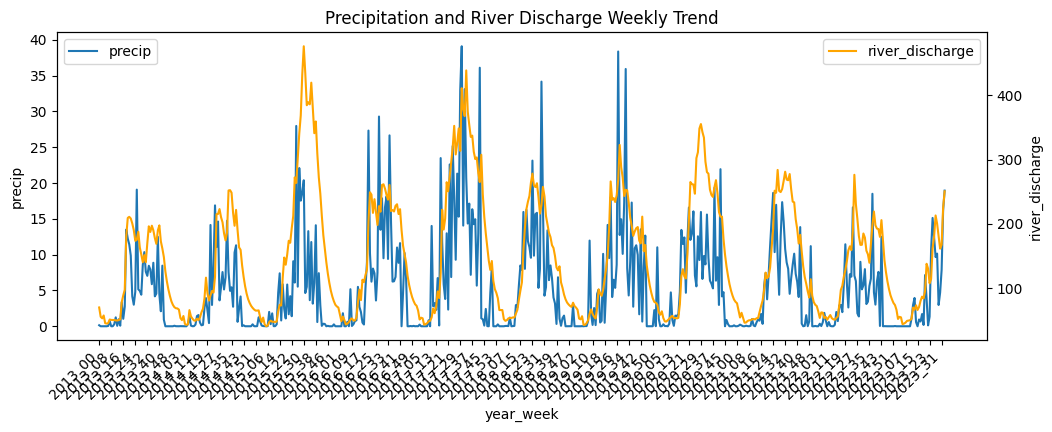

In [76]:
fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()

plt.title("Precipitation and River Discharge Weekly Trend")
sns.lineplot(x=df_groupby_div_week.index, y=df_groupby_div_week['precip'], ax=ax1, label='precip' )
sns.lineplot(x=df_groupby_div_week.index, y=df_groupby_div_week['river_discharge'], ax=ax2, color='orange', label='river_discharge') 

ax1.set_xticks(ax1.get_xticks()[::8])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right', va='top')
plt.xticks(fontsize=6)
ax1.legend(loc='upper left');

### **Collinearity Analysis**
* Temperature-related features are 

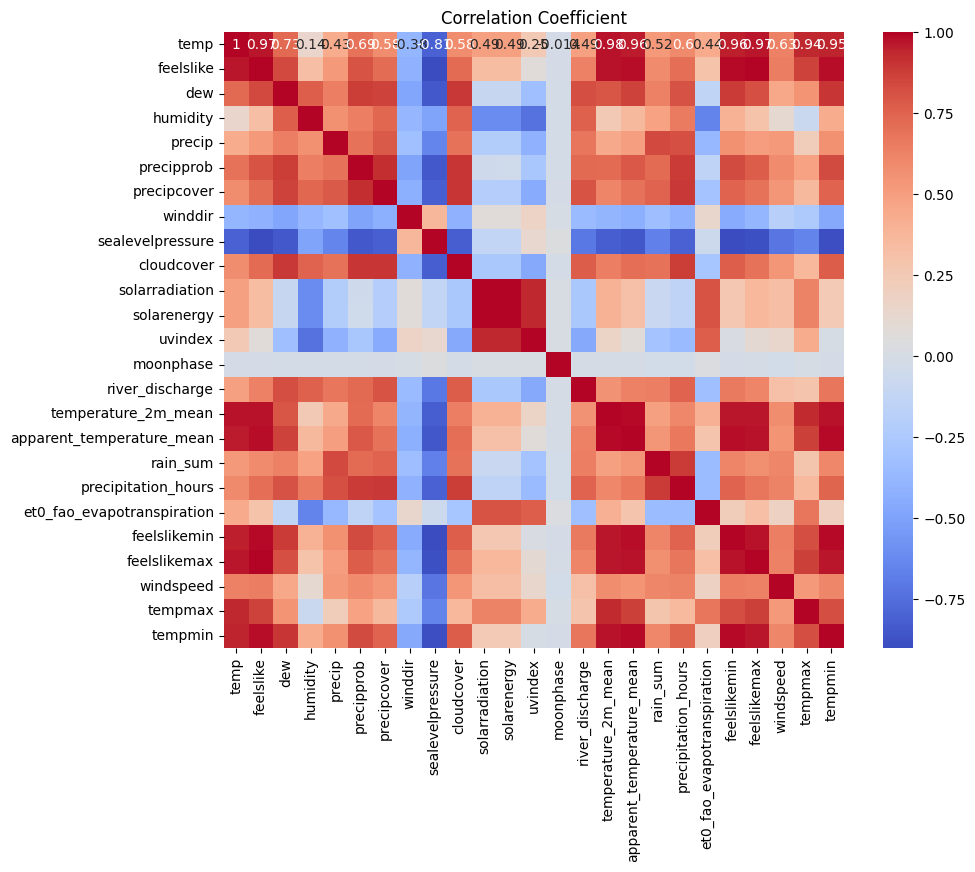

In [77]:
# Observe the correlation
cor = df_groupby_div_week.corr()

plt.figure(figsize=(10, 8))
plt.title("Correlation Coefficient")
sns.heatmap(cor, annot=True, cmap='coolwarm');

In [78]:
cor['temp'].sort_values()

sealevelpressure             -0.809151
winddir                      -0.383253
moonphase                    -0.013638
humidity                      0.139867
uvindex                       0.250965
precip                        0.431665
et0_fao_evapotranspiration    0.441328
river_discharge               0.491681
solarradiation                0.492804
solarenergy                   0.493241
rain_sum                      0.521786
precipcover                   0.580546
cloudcover                    0.582986
precipitation_hours           0.596665
windspeed                     0.629938
precipprob                    0.694498
dew                           0.729336
tempmax                       0.935061
tempmin                       0.945860
feelslikemin                  0.955153
apparent_temperature_mean     0.961767
feelslikemax                  0.967504
feelslike                     0.969270
temperature_2m_mean           0.977719
temp                          1.000000
Name: temp, dtype: float6

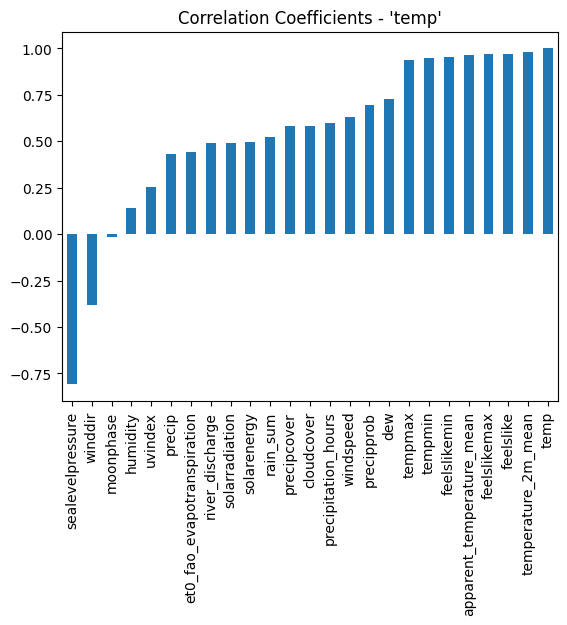

In [79]:
plt.title("Correlation Coefficients - 'temp'")
cor['temp'].sort_values().plot(kind='bar');

In [80]:
cor['sealevelpressure'].sort_values()

feelslikemin                 -0.900212
feelslike                    -0.898871
tempmin                      -0.885950
feelslikemax                 -0.879481
apparent_temperature_mean    -0.850476
dew                          -0.844892
precipprob                   -0.841779
temperature_2m_mean          -0.825772
cloudcover                   -0.822971
precipcover                  -0.816411
temp                         -0.809151
precipitation_hours          -0.806090
windspeed                    -0.721914
river_discharge              -0.701047
rain_sum                     -0.665290
tempmax                      -0.649662
precip                       -0.643442
humidity                     -0.490041
solarenergy                  -0.123609
solarradiation               -0.123245
et0_fao_evapotranspiration   -0.067784
moonphase                     0.036243
uvindex                       0.126689
winddir                       0.373623
sealevelpressure              1.000000
Name: sealevelpressure, d

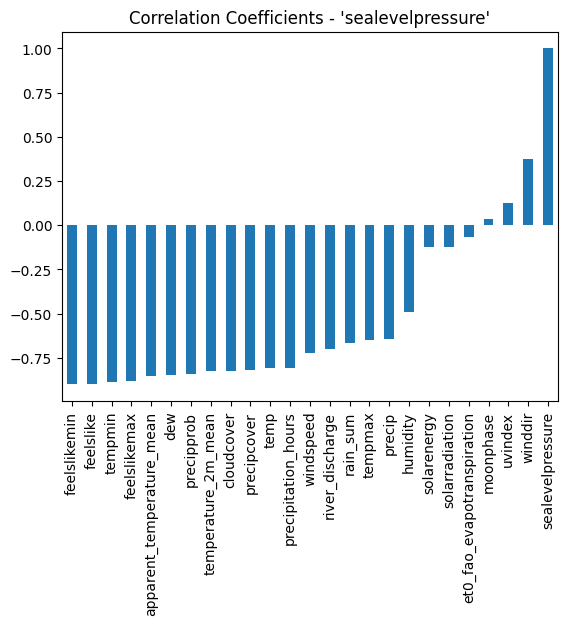

In [81]:
plt.title("Correlation Coefficients - 'sealevelpressure'")
cor['sealevelpressure'].sort_values().plot(kind='bar');

## **Building Model**
* Predict precip' and 'river_discharge'

In [82]:
# Predict 'precip'
X = df_groupby_div_week.drop(['precip', 'river_discharge'], axis=1)
y = df_groupby_div_week[['precip', 'river_discharge']]

In [83]:
print(X.shape, y.shape)

(563, 23) (563, 2)


In [84]:
# Split train, test and validataion
# Train
X_train = X[X.index.str[:4].isin([str(yr) for yr in range(2013, 2020, 1)])]
y_train = y[y.index.str[:4].isin([str(yr) for yr in range(2013, 2020, 1)])][['precip', 'river_discharge']].values
# Test
X_test = X[X.index.str[:4].isin(['2020', '2021'])]
y_test = y[y.index.str[:4].isin(['2020', '2021'])][['precip', 'river_discharge']].values
# Validation
X_validation = X[X.index.str[:4].isin(['2022', '2023'])]
y_validation = y[X.index.str[:4].isin(['2022', '2023'])][['precip', 'river_discharge']].values

In [85]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_validation.shape, y_validation.shape)

(371, 23) (371, 2)
(106, 23) (106, 2)
(86, 23) (86, 2)


## **Normalize the Dataset**

In [86]:
# Normalize train, test and validation datasets
scaler = MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_validation_scaled = scaler.transform(X_validation)

In [87]:
# Create DataFrame
cols = X_train.columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=cols)
X_validation_scaled = pd.DataFrame(X_validation_scaled, columns=cols)

## **Build Base Models**
* RandomForestRegressor
* XGBRegressor
* XGBRFRegressor

In [88]:
# Parameters used for model creation and evaluation 
X_train_weekly = X_train_scaled
y_train_weekly = y_train
X_test_weekly = X_test_scaled
y_test_weekly = y_test

predictions_weekly = {}
score_results_weekly = {}

In [91]:
models = [xgb.XGBRegressor(random_state=327), RandomForestRegressor(random_state=327), xgb.XGBRFRegressor(random_state=327)]
model_names = ['XGBRegressor', 'RandomForestRegressor', 'XGBRFRegressor']
metrics = [r2_score, mean_absolute_error, mean_squared_error]

for i in range(len(models)):
    model = fit_model(models[i], X_train_weekly, y_train_weekly)
    pred = get_prediction(model, X_test_weekly)
    predictions_weekly[model_names[i]] = pred
    scores = []
    for j in range(len(metrics)):
        scores.append(evaluate_model(metrics[j], pred, y_test_weekly))
        if metrics[j] == mean_squared_error:
            scores.append(np.sqrt(evaluate_model(metrics[j], pred, y_test_weekly)))
    score_results_weekly[model_names[i]] = scores


## **Performance Metrics for Base Models**
* RandomForestRegressor
* XGBRegressor
* XGBRFRegressor

**Base Model for Weekly Dataset**

||XGBRegressor|RandomForestRegressor|XGBRFRegressor|
| --- | --- | --- | --- |
|R2|0.690506|0.821772|0.768192|
|MAE|15.191466|13.728657|13.541703|
|MSE|947.747539|746.484344|656.067475|
|RMSE|30.785509|27.321866|25.613814|

In [93]:
# Base model performance scores
metrics.append('root mean squared error')
pd.DataFrame(score_results_weekly, index=['R2', 'MAE', 'MSE', 'RMSE'])

,XGBRegressor,RandomForestRegressor,XGBRFRegressor
R2,0.690506,0.821772,0.768192
MAE,15.191466,13.728657,13.541703
MSE,947.747539,746.484344,656.067475
RMSE,30.785509,27.321866,25.613814


## **Hyperparameter Tuning**

* RandomForestRegressor model
* best_rfr_params = {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}

-- Skip the below cell from the next time

In [94]:
# Define the parameter grid
rfr_params = {
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a base model
rfr_model = RandomForestRegressor(random_state=327)

# Instantiate the random search model
rfr_random_search = RandomizedSearchCV(estimator=rfr_model, 
                                       param_distributions=rfr_params, 
                                       n_iter=100, 
                                       cv=5, 
                                       verbose=2, 
                                       n_jobs=-1)

# Fit rfr_random_search and get the best hyperparameters
rfr_random_search.fit(X_train_scaled, y_train)
best_rfr_params = rfr_random_search.best_params_

# Create RandomForestRegressor with the best hyperparameters
best_rfr_model = RandomForestRegressor(**best_rfr_params)

# Train the model
best_rfr_model.fit(X_train, y_train)

# RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=4,
#                       n_estimators=200)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomForestRegressor(max_depth=30, max_features='sqrt', n_estimators=1400)

In [95]:
print(best_rfr_params)

{'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


-- Run the below cell to create the best RandomForestRegressor model

In [211]:
# Best hyperparameters for RandomForestRegressor
best_rfr_params = {'n_estimators': 1400, 
                   'min_samples_split': 2, 
                   'min_samples_leaf': 1, 
                   'max_features': 'sqrt', 
                   'max_depth': 30, 
                   'bootstrap': True}
# Best RandomForestRegressor model
best_rfr_model = RandomForestRegressor(**best_rfr_params)
# Train the model
best_rfr_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=40, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=200)

* XGBoostRegressor
* best_xgb_params = {'reg_lambda': 2, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.8, 'booster': 'gbtree'}

-- Skip the below cell from the next time

In [96]:
# Define the parameter grid
xgb_params = {
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, 15],
    'min_child_weight': [1, 2, 3],
    'colsample_bytree': [0.8, 0.9, 1],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0.5, 1, 2],
    'reg_lambda': [1, 2, 3],
    'gamma': [0, 1, 2]
}

# Create an XGBRegressor object
xgb_model = xgb.XGBRegressor(random_state=327)

# Create a RandomizedSearchCV object
xgb_random_search = RandomizedSearchCV(
                    estimator=xgb_model,
                    param_distributions=xgb_params,
                    n_iter=100,
                    cv=5,
                    scoring='neg_mean_absolute_error',
                    verbose=5,
                    n_jobs=12
)

# Fit xgb_random_search and get the best hyperparameters
xgb_random_search.fit(X_train_scaled, y_train)
best_xgb_params = xgb_random_search.best_params_

# Create xgb.XGBRegressor with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(**best_xgb_params)

# Train the model
best_xgb_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [97]:
print(best_xgb_params)

{'reg_lambda': 2, 'reg_alpha': 1, 'objective': 'reg:squarederror', 'n_estimators': 200, 'min_child_weight': 2, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.8, 'booster': 'gbtree'}


-- Run the below cell to create the best XGBRegressor model

In [ ]:
# Best hyperparameters for XGBRegressor
best_xgb_params = {'reg_lambda': 2, 
                   'reg_alpha': 1, 
                   'objective': 'reg:squarederror', 
                   'n_estimators': 200, 
                   'min_child_weight': 2, 
                   'max_depth': 15, 
                   'learning_rate': 0.1, 
                   'gamma': 2, 
                   'colsample_bytree': 0.8, 
                   'booster': 'gbtree'}
# Create xgb.XGBRegressor with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(**best_xgb_params)

# Train the model
best_xgb_model.fit(X_train, y_train)               

* XGBRFRegressor
* best_xgbrf_model = {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 10, 'gamma': 0.3, 'colsample_bytree': 0.6}

-- Skip the below cell from the next time

In [98]:
# Define the hyperparameter search space
xgbrf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_child_weight': [1, 2, 3, 4],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgbrf_model = xgb.XGBRFRegressor(random_state=327)

# Create a RandomizedSearchCV object
xgbrf_random_search = RandomizedSearchCV(
                      estimator=xgbrf_model,
                      param_distributions=xgbrf_params,
                      n_iter=100,
                      cv=5,
                      verbose=2,
                      n_jobs=-1
)

# Fit xgbrf_random_search and get the best hyperparameters
xgbrf_random_search.fit(X_train_scaled, y_train)
best_xgbrf_params = xgbrf_random_search.best_params_

# Create xgb.XGBRegressor with the best hyperparameters
best_xgbrf_model = xgb.XGBRFRegressor(**best_xgbrf_params)

# Train the model
best_xgbrf_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
print(best_xgbrf_params)

{'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 10, 'gamma': 0.3, 'colsample_bytree': 0.6}


-- Run the below cell to create the best XGBRFRegressor model

In [ ]:
# Best hyperparameters for XGBRFRegressor
best_xgbrf_params = {'subsample': 0.6, 
                     'n_estimators': 300, 
                     'min_child_weight': 4, 
                     'max_depth': 10, 
                     'gamma': 0.3, 
                     'colsample_bytree': 0.6}

# Create xgb.XGBRFRegressor with the best hyperparameters
best_xgbrf_model = xgb.XGBRegressor(**best_xgbrf_params)

# Train the model
best_xgbrf_model.fit(X_train, y_train)               

In [125]:
# Best hyperparameters for XGBRFRegressor
best_abdr_params = {'n_estimators': 200, 'loss': 'linear', 'learning_rate': 0.05}

# Create xgb.XGBRFRegressor with the best hyperparameters
best_abdr_model = AdaBoostRegressor(**best_abdr_params)

# Train the model
best_abdr_model.fit(X_train, y_train)               

AdaBoostRegressor(learning_rate=0.05, n_estimators=200)

## **Performance Metrics for the Best Models**
* RandomForestRegressor
* XGBRegressor
* XGBRFRegressor

In [ ]:
# Parameters used for model creation and evaluation 
# X_train_weekly = X_train_scaled
# y_train_weekly = y_train
# X_test_weekly = X_test_scaled
# y_test_weekly = y_test

tuned_predictions_weekly = {}
tuned_score_results_weekly = {}

In [ ]:
# Fit the RandomizedSearchCV object to the data
tuned_models = [best_rfr_model, best_xgb_model, best_xgbrf_model, best_abdr_model]
tuned_model_names = ['Tuned XGBRegressor', 'Tuned RandomForestRegressor', 'Tuned XGBRFRegressor', 'AdaBoostRegressor']
# rs_best_models = []

for i in range(len(tuned_models)):
    model = tuned_models[i]
    pred = get_prediction(model, X_test_weekly )
    tuned_predictions_weekly.append(pred)
    tuned_score_results_weekly = []
    for j in range(len(metrics)):
        scores.append(evaluate_model(metrics[j], pred, y_test_weekly))
        if metrics[j] == mean_squared_error:
            scores.append(np.sqrt(evaluate_model(metrics[j], pred, y_test_weekly)))
    tuned_score_results_weekly[tuned_model_names[i]] = scores

TypeError: 'str' object is not callable

In [108]:
score_results

{'XGBRegressor': [0.7659, 1.7816, 7.9014, 2.8109429023016457],
 'RandomForestRegressor': [0.5559, 2.1414, 14.988, 3.871433842906269],
 'XGBRFRegressor': [0.7555, 1.7672, 8.2521, 2.8726468630863766],
 'Tuned XGBRegressor': [0.7659, 1.7816, 7.9014, 2.8109429023016457],
 'Tuned RandomForestRegressor': [0.5559, 2.1414, 14.988, 3.871433842906269],
 'Tuned XGBRFRegressor': [0.7555, 1.7672, 8.2521, 2.8726468630863766]}

In [112]:
pd.DataFrame(score_results, index=['R2', 'MAE', 'MSE', 'RMSE'])

,XGBRegressor,RandomForestRegressor,XGBRFRegressor,Tuned XGBRegressor,Tuned RandomForestRegressor,Tuned XGBRFRegressor
R2,0.510400,0.724500,0.657500,0.765900,0.555900,0.755500
MAE,2.057500,1.860300,1.911700,1.781600,2.141400,1.767200
MSE,16.523600,9.299500,11.558400,7.901400,14.988000,8.252100
RMSE,4.064923,3.049508,3.399765,2.810943,3.871434,2.872647
